# Importing the required libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, roc_curve,
                             roc_auc_score, confusion_matrix,
                             f1_score, log_loss, precision_recall_curve,
                             average_precision_score, confusion_matrix, 
                             classification_report)

%matplotlib inline

# Loading the dataset

In [34]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
X_train, y_train = (train_data.drop('class of diagnosis', axis=1),
                    train_data['class of diagnosis'])
X_test, y_test = test_data.drop('class of diagnosis', axis=1), test_data['class of diagnosis']
n_samples, n_features = X_train.shape
seed = 123

# Hyperparameter tuning

In [25]:
model = RandomForestClassifier(random_state=seed, n_jobs=-1)

In [35]:
param_grid = {
    'n_estimators': [10, 100, 500, 1000],
    'max_depth': [3, 10, None],
    'max_features': range(1, n_features + 1),
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 3, 5]
}

grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
best = grid_search.best_params_
print('Parameters chosen:')
print(*['{}: {}'.format(parameter, value)
        for parameter, value in zip(best.keys(), best.values())], sep='\n')

Parameters chosen:
max_depth: 10
max_features: 33
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 100


# Model evaluation

### Various metrics

In [36]:
print('Evaluataion with 5-fold cross validation:')
for metric in ('accuracy', 'neg_log_loss', 'f1', 'roc_auc'):
    score = np.mean(cross_val_score(grid_model,
                                    X_train,
                                    y_train,
                                    scoring=metric,
                                    cv=5,
                                    n_jobs=-1))
    print('{:<10}\t {}'.format(metric, score))


Evaluataion with 5-fold cross validation:
accuracy  	 0.7719115512678221
neg_log_loss	 -0.5718360350717407
f1        	 0.5115011655011654
roc_auc   	 0.6811782212885155


In [37]:
grid_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=33, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

### Feature importance

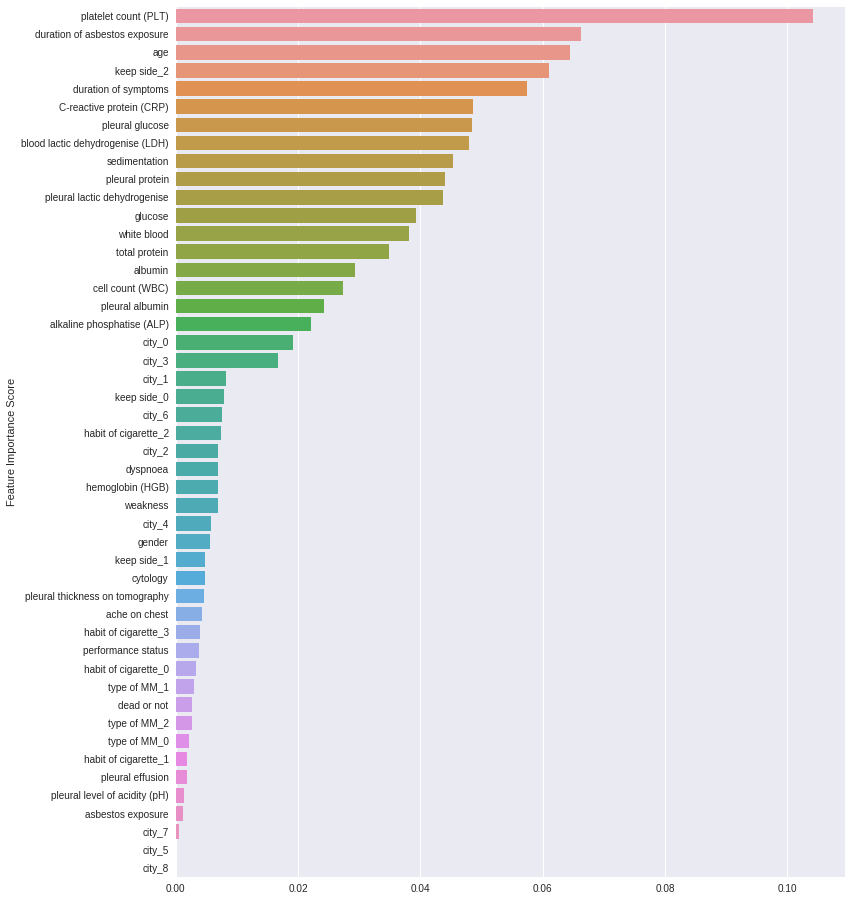

In [38]:
f_imp = pd.Series(grid_model.feature_importances_, X_train.columns)
f_imp = f_imp.sort_values(ascending=False)
plt.figure(figsize=(12,16))
f_imp_plot = sns.barplot(y=f_imp.index, x=f_imp.values)
plt.ylabel('Feature Importance Score')
plt.show()

### We can see a steady decrease in feature importance and a sharp drop after 'city_3'. Let's trim some features away and train the model on that.

In [39]:
high_importance = f_imp[f_imp > f_imp['city_3']].index
X_train_new = X_train[high_importance]
_, n_samples_new = X_train_new.shape
best['max_features'] = min(n_samples_new, best['max_features'])
model_new = RandomForestClassifier(**best)
print('Evaluataion with 5-fold cross validation:')
for metric in ('accuracy', 'neg_log_loss', 'f1', 'roc_auc'):
    score = np.mean(cross_val_score(model_new,
                                    X_train_new,
                                    y_train,
                                    scoring=metric,
                                    cv=5,
                                    n_jobs=-1))
    print('{:<10}\t {}'.format(metric, score))

Evaluataion with 5-fold cross validation:
accuracy  	 0.7568954722672814
neg_log_loss	 -0.5901515720210609
f1        	 0.485388041909781
roc_auc   	 0.6584780578898226


### I don't think the drop in performance is worth it. Let's use the original model.

### Boxplots of predicted class probabilities and a confusion matrix for the training set. Just to make sure everything is working correctly so far.

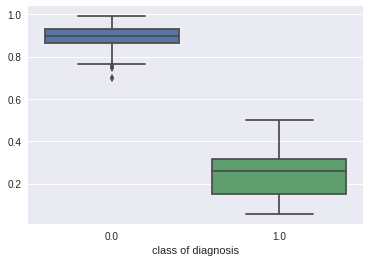

In [40]:
pred_train = grid_model.predict(X_train)
pred_prob_train = grid_model.predict_proba(X_train)
sns.boxplot(y_train, pred_prob_train.T[0])
plt.show()

In [41]:
pd.DataFrame(data=confusion_matrix(y_train, pred_train),
             columns=('predicted_negative', 'predicted_positive'),
             index=('actual_negative', 'actual_positive'))

,predicted_negative,predicted_positive
actual_negative,178,0
actual_positive,0,81


### Nicely separated. Time for predictions.

# Performance on the test set

### Class probabilities again, this time for the test set.

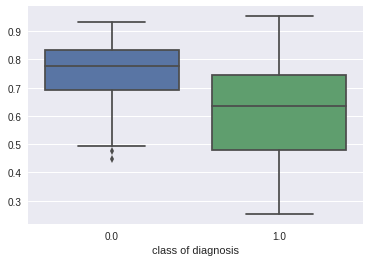

In [42]:
pred = grid_model.predict(X_test)
pred_prob = grid_model.predict_proba(X_test)
sns.boxplot(y_test, pred_prob.T[0])
plt.show()

### Precision, recall, f1

In [43]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.82      0.94      0.88        50
        1.0       0.62      0.33      0.43        15

avg / total       0.78      0.80      0.78        65



### Confusion Matrix

In [44]:
pd.DataFrame(data=confusion_matrix(y_test, pred),
             columns=('predicted_negative', 'predicted_positive'),
             index=('actual_negative', 'actual_positive'))

,predicted_negative,predicted_positive
actual_negative,47,3
actual_positive,10,5


### ROC curve

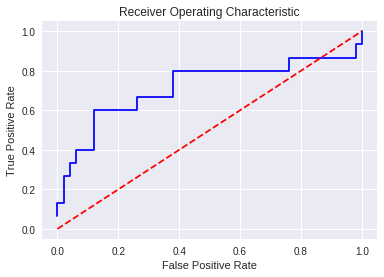

Area under curve: 0.716


In [45]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob.T[1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc = roc_auc_score(y_test, pred_prob.T[1])
print(''.join(('Area under curve: ', str(roc_auc))))

### Precision-recall curve

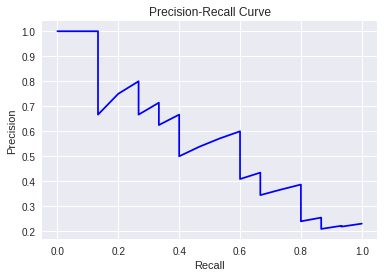

Area under curve: 0.554817265957


In [46]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob.T[1])
plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'b')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
prec_recall = average_precision_score(y_test, pred_prob.T[1])
print(''.join(('Area under curve: ', str(prec_recall))))